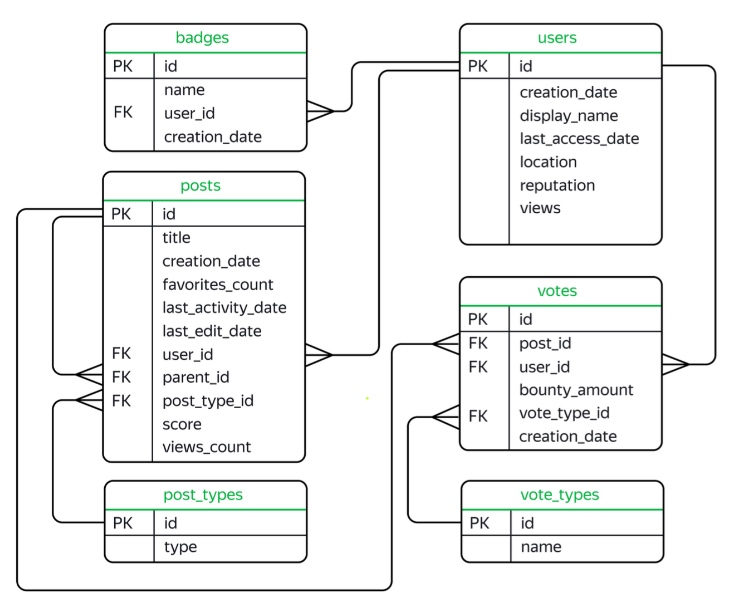

## Задания (Первая часть)

1. Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

In [ ]:
SELECT COUNT(title)
FROM stackoverflow.posts
WHERE score > 300
      OR favorites_count >= 100

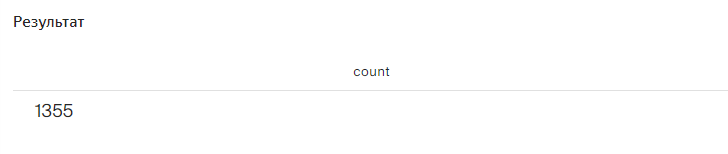

2. Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

In [ ]:
SELECT ROUND(SUM(avg.day_cnt) / COUNT(avg.day_cnt))
FROM
    (SELECT creation_date::date,
           COUNT(title) AS day_cnt
    FROM stackoverflow.posts AS p
    LEFT JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
    WHERE pt.type = 'Question'
          AND creation_date::date BETWEEN '2008-11-01' AND '2008-11-18'
    GROUP BY creation_date::date) AS avg;

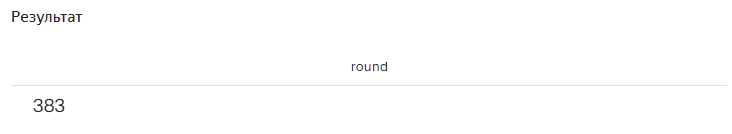

3.Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

In [ ]:
SELECT COUNT(DISTINCT user_id)
FROM stackoverflow.badges AS b
LEFT JOIN stackoverflow.users AS u ON b.user_id = u.id
WHERE u.creation_date :: date = b.creation_date :: date;

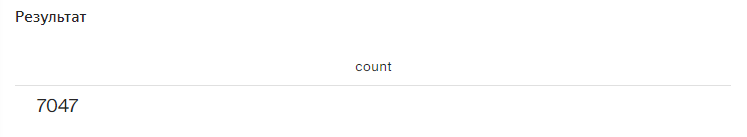

4.Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

In [ ]:
SELECT COUNT(DISTINCT(p.id))
FROM stackoverflow.posts AS p
JOIN stackoverflow.votes AS v ON p.id = v.post_id
JOIN stackoverflow.users AS u ON p.user_id = u.id
WHERE u.display_name = 'Joel Coehoorn'
      AND v.id >= 1;

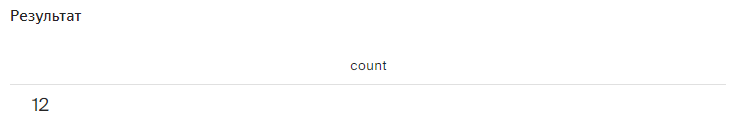

5.Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id.

In [ ]:
SELECT *,
       ROW_NUMBER() OVER (ORDER BY id DESC) AS rank
FROM stackoverflow.vote_types
ORDER BY id;

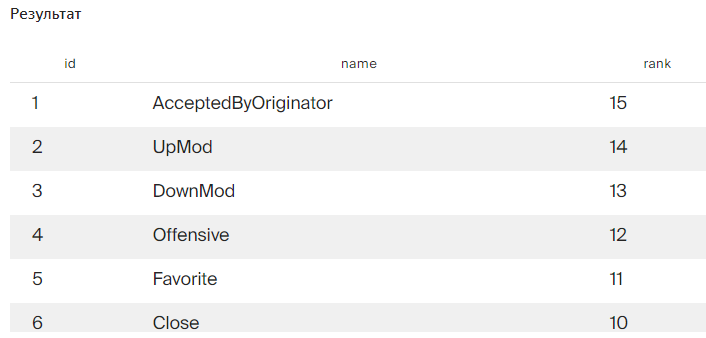

6.Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

In [ ]:
SELECT v.user_id,
       COUNT(name)
FROM stackoverflow.votes AS v
JOIN stackoverflow.vote_types AS vt ON v.vote_type_id = vt.id
WHERE name LIKE 'Close'
GROUP BY v.user_id
ORDER BY COUNT(name) DESC
LIMIT 10;

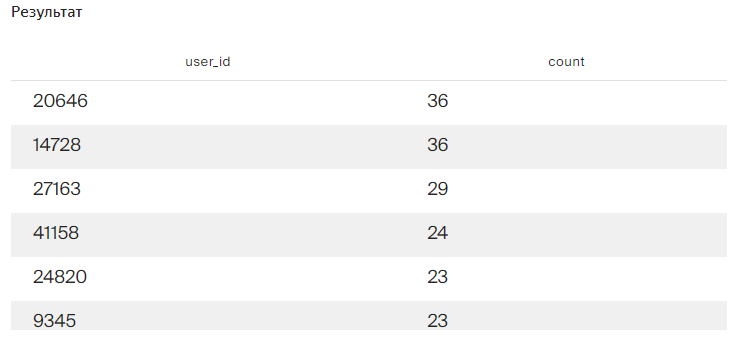

7.Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно.
Отобразите несколько полей:
идентификатор пользователя;
число значков;
место в рейтинге — чем больше значков, тем выше рейтинг.
Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

In [ ]:
SELECT user_id,
       COUNT(id) AS badges_cnt,
       DENSE_RANK() OVER (ORDER BY COUNT(id) DESC) AS rating
FROM stackoverflow.badges
WHERE creation_date::date BETWEEN '2008-11-15' AND '2008-12-15'
GROUP BY user_id
ORDER BY rating, user_id
LIMIT 10;

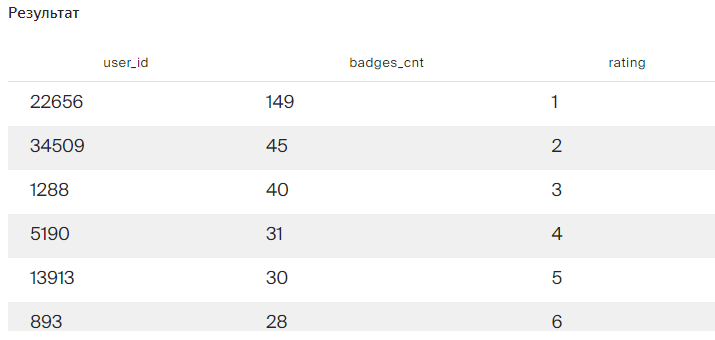

8.Сколько в среднем очков получает пост каждого пользователя?
Сформируйте таблицу из следующих полей:
заголовок поста;
идентификатор пользователя;
число очков поста;
среднее число очков пользователя за пост, округлённое до целого числа.
Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

In [ ]:
SELECT title,
       user_id,
       SUM(score),
       ROUND(AVG(score) OVER (PARTITION BY user_id)) AS avg_sc
FROM stackoverflow.posts
WHERE title IS NOT NULL
      AND score <> 0
GROUP BY title, user_id, score;

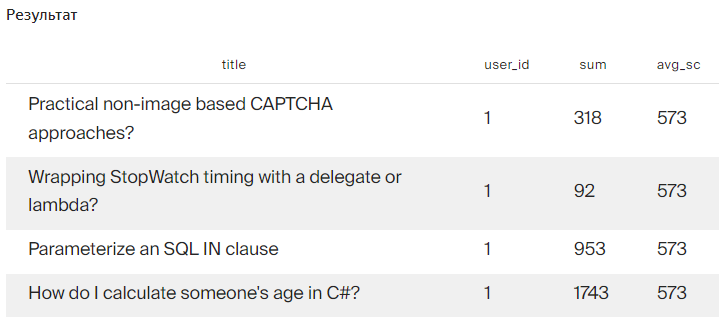

9.Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

In [ ]:
SELECT p.title
       --COUNT(b.id)
FROM stackoverflow.badges AS b
JOIN stackoverflow.users AS u ON b.user_id = u.id
JOIN stackoverflow.posts AS p ON b.user_id = p.user_id
GROUP BY p.title
HAVING p.title IS NOT NULL
       AND COUNT(b.id) > 1000;

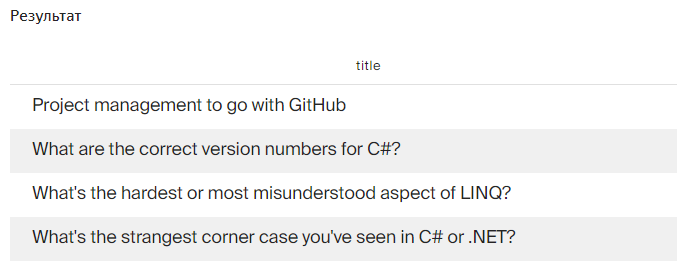

10.Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:
пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
пользователям с числом просмотров меньше 100 — группу 3.
Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу.

In [ ]:
SELECT id,
       views,
       CASE
           WHEN views < 100 THEN 3
           WHEN views >= 100 AND views < 350 THEN 2
           WHEN views >= 350 THEN 1
        END as grp
FROM stackoverflow.users
WHERE location LIKE '%United States%' 
               AND views <> 0;

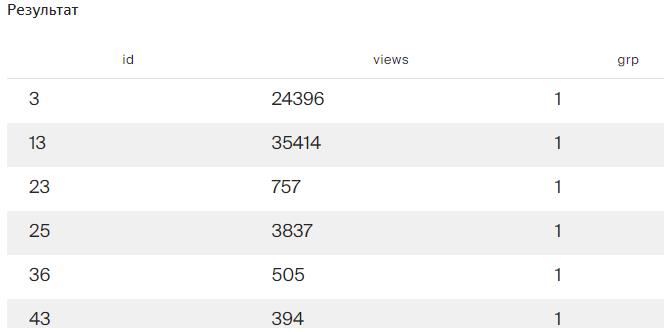

11.Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

In [ ]:
WITH grp AS
    (SELECT id,
            views,
            CASE
               WHEN views < 100 THEN 3
               WHEN views >= 100 AND views < 350 THEN 2
               WHEN views >= 350 THEN 1
             END AS user_grp
    FROM stackoverflow.users
    WHERE location LIKE '%United States%' 
                   AND views <> 0),
max_grp AS
    (SELECT MAX(views) AS max_views,
            user_grp
    FROM grp
    GROUP BY user_grp)
SELECT gp.id,
       mg.user_grp,
       gp.views
FROM max_grp AS mg
JOIN grp AS gp ON mg.max_views = gp.views   
ORDER BY gp.views DESC, gp.id;

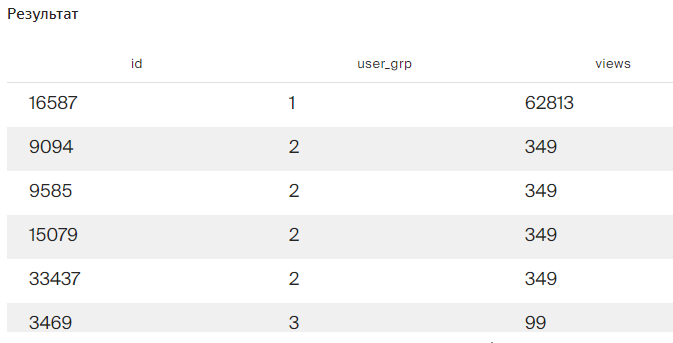

12.Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
номер дня;
число пользователей, зарегистрированных в этот день;
сумму пользователей с накоплением.

In [ ]:
SELECT *,
       SUM(cnt.new_users) OVER (ORDER BY cnt.dt) AS total
FROM
    (SELECT EXTRACT(DAY FROM creation_date::date) AS dt,
            COUNT(id) AS new_users
    FROM stackoverflow.users
    WHERE creation_date::date BETWEEN '2008-11-01' AND '2008-11-30'
    GROUP BY dt) AS cnt

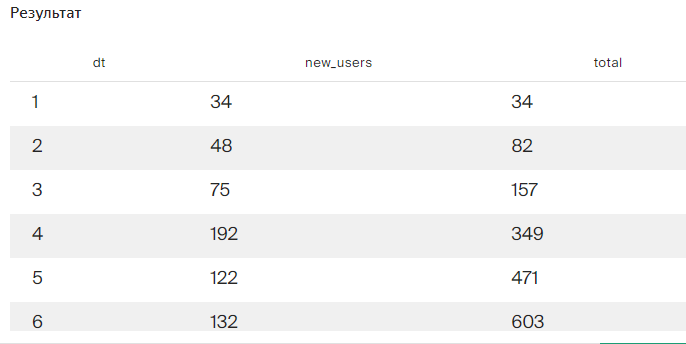

13.Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
идентификатор пользователя;
разницу во времени между регистрацией и первым постом.

In [ ]:
WITH first_post AS
    (SELECT DISTINCT(user_id),
            FIRST_VALUE(creation_date) OVER (PARTITION BY user_id ORDER BY creation_date) AS fc
    FROM stackoverflow.posts
    WHERE creation_date IS NOT NULL)
SELECT first_post.user_id,
       (first_post.fc - u.creation_date) AS dif
FROM stackoverflow.users AS u
JOIN first_post ON u.id = first_post.user_id;

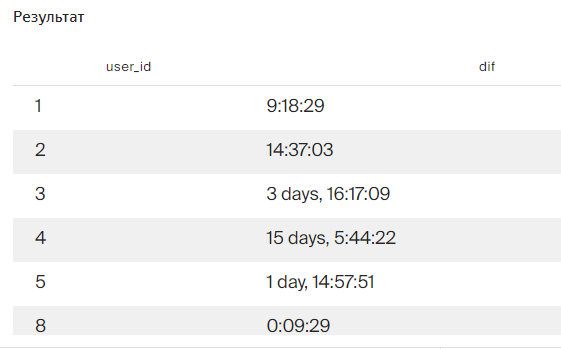

## Задания (Вторая часть)

1.Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [ ]:
SELECT DISTINCT 
       DATE_TRUNC('month', creation_date)::date AS dt,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date)::date) AS summ
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date)::date BETWEEN '2008-01-01' AND '2008-12-31'
ORDER BY summ DESC;

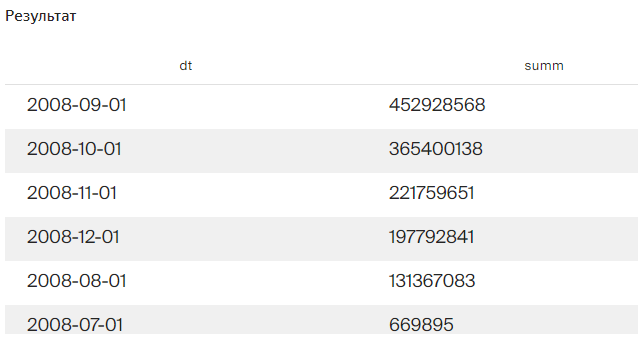

2.Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений user_id. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [ ]:
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id = p.user_id
JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE p.creation_date::date BETWEEN u.creation_date::date AND (u.creation_date::date + INTERVAL '1 month') 
      AND pt.type LIKE 'Answer'
GROUP BY u.display_name
HAVING COUNT(pt.id) > 100
ORDER BY u.display_name;

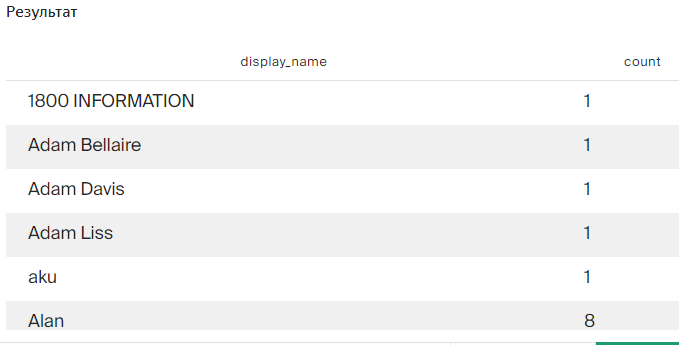

3.Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [ ]:
WITH sorted_users AS
    (SELECT u.id
    FROM stackoverflow.users AS u
    JOIN stackoverflow.posts AS p ON u.id=p.user_id
    WHERE DATE_TRUNC('month', u.creation_date)::date = '2008-09-01'
          AND DATE_TRUNC('month', p.creation_date)::date = '2008-12-01'
    GROUP BY u.id
    HAVING COUNT(p.id) > 0)
SELECT COUNT(p.id),
       DATE_TRUNC('month', p.creation_date)::date
FROM stackoverflow.posts AS p
WHERE p.user_id IN (SELECT *
                    FROM sorted_users)
      AND DATE_TRUNC('year', p.creation_date)::date = '2008-01-01'
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC;

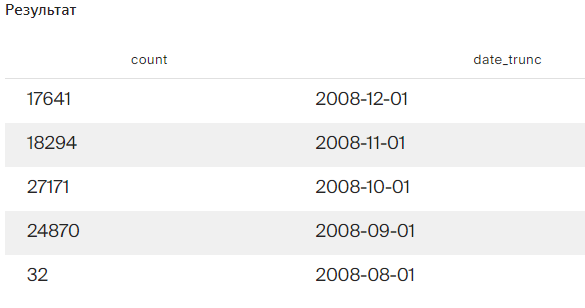

4.Используя данные о постах, выведите несколько полей:
идентификатор пользователя, который написал пост;
дата создания поста;
количество просмотров у текущего поста;
сумму просмотров постов автора с накоплением.
Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [ ]:
SELECT DISTINCT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id ASC, creation_date ASC;

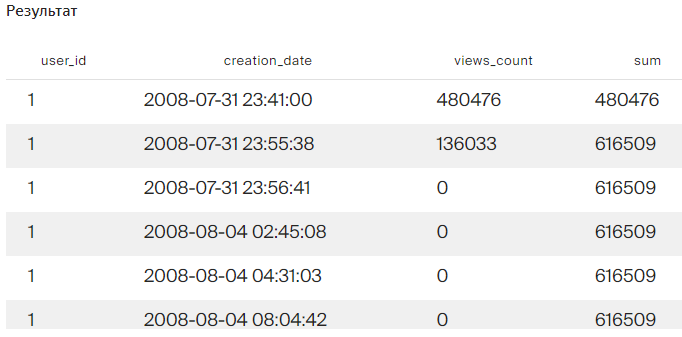

5.Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.

In [ ]:
WITH users AS (SELECT DISTINCT user_id,
                      COUNT(DISTINCT creation_date::date) AS dt
               FROM stackoverflow.posts
               WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07' 
               GROUP BY user_id)
SELECT ROUND(AVG(users.dt))
FROM users;

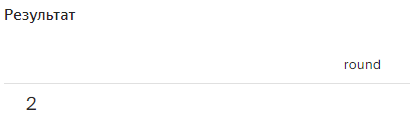

6.На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:
номер месяца;
количество постов за месяц;
процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.
Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.
Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип numeric.

In [ ]:
WITH users AS
   (SELECT EXTRACT(MONTH FROM creation_date::date) AS mnth,
           COUNT(p.id) AS users_cnt
    FROM stackoverflow.posts AS p
    WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
    GROUP BY mnth)
SELECT *,
       ROUND(((users_cnt::numeric / LAG(users_cnt) OVER (ORDER BY mnth)) - 1) * 100, 2) AS rate
FROM users;

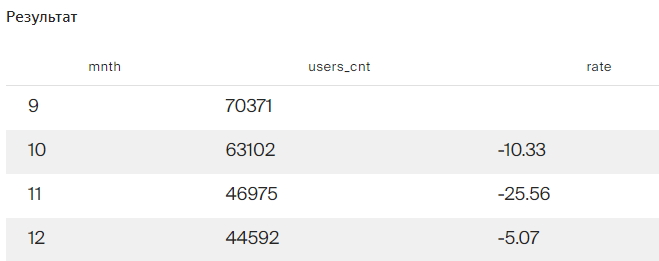

7.Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:
номер недели;
дата и время последнего поста, опубликованного на этой неделе.

In [ ]:
SELECT DISTINCT EXTRACT(WEEK FROM creation_date) AS dt,
       MAX(creation_date)
FROM stackoverflow.posts
WHERE user_id = '22656'
      AND DATE_TRUNC('month', creation_date) = '2008-10-1'
GROUP BY dt;

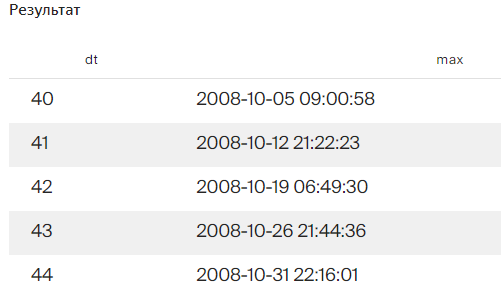